In [160]:
import numpy as np
from sympy.physics.wigner import wigner_3j
import matplotlib.pyplot as plt
import cmath
from scipy.special import lpmn


In [170]:
def potential( r, th, C_12, alpha, mu ):
    return C_12 / r**12 - alpha * mu**2 / 2 / r**6 * ( 1 + 3 * np.cos(th)**2 )

def get_Pleg_matrix( N, m ):

    l_max = N + abs(m) - 1

    x_arr, w = np.polynomial.legendre.leggauss(N)
    
    P_lm = np.zeros( (N,N) )

    l_arr = np.arange( 0, N ) + abs(m)
    norm = np.sqrt( (l_arr + 0.5) / np.array( [ np.prod( np.arange( l-abs(m)+1, l+abs(m)+1 ) ) for l in l_arr ] ) )

    for i, x in enumerate(x_arr):

        lpmn_at_x, _ = lpmn( m, l_max, x )

        P_lm[i,:] = lpmn_at_x[ abs(m), abs(m): ] * norm * np.sqrt( w[i] )

    if m != 0:

        Q, R = np.linalg.qr( np.transpose( P_lm ) )

        U = Q

    else:
        U = np.transpose( P_lm )

    return U

def get_laplacian_matrix( N, m ):

    U = get_Pleg_matrix( N, m )

    l_arr = np.arange( 0, N ) + abs(m)

    L2 = np.matmul( np.matmul( np.transpose(U), np.diag( l_arr * ( l_arr + 1 ) ) ), U )

    return L2

def force_field( r, th, C_12, alpha, mu ):
    F_r = - 12 * C_12 / r**13 - 6 * alpha * mu**2 / 2 / r**7 * ( 1 + 3 * np.cos( th )**2 )
    F_th = - 3 * alpha * mu**2 / 2 / r**6 * np.sin( 2 * th )

    return F_r, F_th

In [162]:
def evolution( V, C_12, alpha, mu, m_Ne, m_HYQ, Be, l_max, m, laplacian, th_arr ):

    mass = 1./( 1./m_Ne + 1./m_HYQ )

    r = V[0]
    th = V[1]

    Psi = V[4:]

    der_V = np.zeros_like( V )

    der_V[0] = V[2] / mass
    der_V[1] = 2 * V[3] / m_HYQ

    der_V[2], der_V[3] = force_field( r, th )

    der_V[4:] = - 1j * np.matmul( - laplacian * Be + np.diag( potential( r, th_arr, C_12, alpha, mu ) ), Psi )

    return der_V


In [167]:
N_states = 5
omega = 0

C_12 = 2.5e7
mu = 1*2.38*0.393456
alpha = 27.6 / 0.529177**3

# Be = 
# Re = 



lap = get_laplacian_matrix(N_states, 0)

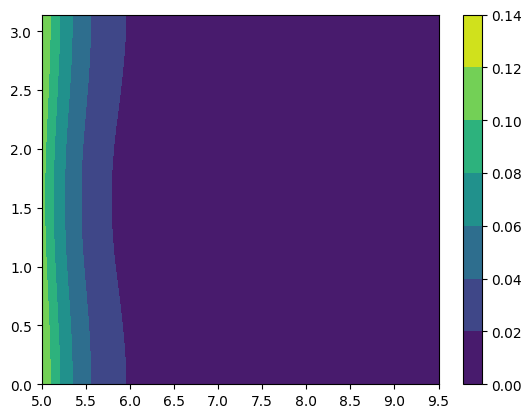

In [171]:
r = np.linspace( 5, 9.5 )
th = np.linspace( 0, np.pi )

r_gr, th_gr = np.meshgrid( r, th )

V = potential( r_gr, th_gr, C_12, alpha, mu )

plt.contourf( r_gr, th_gr, V )
plt.colorbar()